In [1]:
from pathlib import Path
from datetime import datetime
import json

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.vary_play_param_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5

TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [7]:
def create_channel_subset_permutation_experiment(
    permutation_subset_size=3, **experiment_kwargs
):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': 0,
            'message_permutation': True,
            'permutation_subset_size': permutation_subset_size,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        lr=1e-2,
        name='channel_subset_permutation',
        **experiment_kwargs
    )

# Run Experiments

In [8]:
BASE_FOLDER = './experiments/subset_permutation'
Path(BASE_FOLDER).mkdir(exist_ok=True)

# EXPERIMENT_FOLDER = f'{BASE_FOLDER}/{datetime.now().strftime("%d-%m_%H-%M")}'

# EXPERIMENT_FOLDER = "./experiments/message_mutation_3"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/24-09_09-40"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/03-10_02-03"

EXPERIMENT_FOLDER = "./experiments/subset_permutation/05-10_22-03"
Path(EXPERIMENT_FOLDER).mkdir(exist_ok=True)
EXPERIMENT_FOLDER

'./experiments/subset_permutation/05-10_22-03'

In [9]:
experiment = VaryPlayParamExperiment(
    save_location=EXPERIMENT_FOLDER,
    param_vals=[4, 5],
    param_name='permutation_subset_size',
    max_epochs=200,
    num_experiments_per_val=3,
    create_experiment_fn=create_channel_subset_permutation_experiment
)

In [11]:
experiment.run()

Running vary_pm_experiment...
meta_experiment_permutation_subset_size=2 results:  [0.38125, 0.40625]
meta_experiment_permutation_subset_size=3 results:  [0.34375, 0.34375]
meta_experiment_permutation_subset_size=4 results:  [0.45, 0.325]
meta_experiment_permutation_subset_size=5 results:  [0.34375, 0.41875]
Run Stopped.


In [12]:
grand_total = 0
for item_1 in experiment.experiments:
    for item_2 in item_1['experiment'].experiments:
        total_time = sum([
            x['seconds_taken']
            for x in item_2['experiment'].training_history
        ])
        print(int(total_time / 3600), 'hours,', int(total_time / 60) % 60, 'mins and', 
              int(total_time) % 60, 'seconds taken for experiment', 
              f"{experiment.param_name}={item_1[experiment.param_name]}_{item_2['index']}")
        grand_total += total_time
    print()
    
print(int(grand_total / 3600), 'hours,', int(grand_total / 60) % 60, 'mins and', 
      int(grand_total) % 60, 'seconds taken for whole experiment')

0 hours, 0 mins and 15 seconds taken for experiment permutation_subset_size=2_0
0 hours, 0 mins and 17 seconds taken for experiment permutation_subset_size=2_1

0 hours, 0 mins and 18 seconds taken for experiment permutation_subset_size=3_0
0 hours, 0 mins and 16 seconds taken for experiment permutation_subset_size=3_1

0 hours, 0 mins and 15 seconds taken for experiment permutation_subset_size=4_0
0 hours, 0 mins and 15 seconds taken for experiment permutation_subset_size=4_1

0 hours, 0 mins and 16 seconds taken for experiment permutation_subset_size=5_0
0 hours, 0 mins and 18 seconds taken for experiment permutation_subset_size=5_1

0 hours, 2 mins and 14 seconds taken for whole experiment


In [28]:
X_NAME = 'Permuted Proportion'

In [41]:
zs_coord_df = pd.DataFrame([
    {
        X_NAME: item[experiment.param_name] / CHANNEL_SIZE,
        'Zero-Shot Coordination Score': metrics['mean_ground_truth_f1'],
    }
    for item in experiment.experiments
    if item['status'] == 'Complete'
    for stranger_pairings in item['results']
    for metrics in stranger_pairings['vanilla_params_test_metrics']
])

zs_coord_training_params_df = pd.DataFrame([
    {
        X_NAME: item[experiment.param_name] / CHANNEL_SIZE,
        'Zero-Shot Coordination Score': metrics['mean_ground_truth_f1'],
    }
    for item in experiment.experiments
    if item['status'] == 'Complete'
    for stranger_pairings in item['results']
    for metrics in stranger_pairings['vanilla_params_test_metrics']
])

In [42]:
self_play_df = pd.DataFrame([
    {
        X_NAME: item_1[experiment.param_name] / CHANNEL_SIZE,
        'Self-play Performance': 
            item_2['experiment'].results['vanilla_params_results']['ground_truth_acc'],
    }
    for item_1 in experiment.experiments
    if item_1['status'] == 'Complete'
    for item_2 in item_1['experiment'].experiments
    if item_2['status'] == 'Complete'
])

In [43]:
zs_coord_df.head()

,Permuted Proportion,Zero-Shot Coordination Score
0,0.4,0.38125
1,0.4,0.40625
2,0.6,0.34375
3,0.6,0.34375
4,0.8,0.45000


In [44]:
sns.reset_defaults()
sns.set()

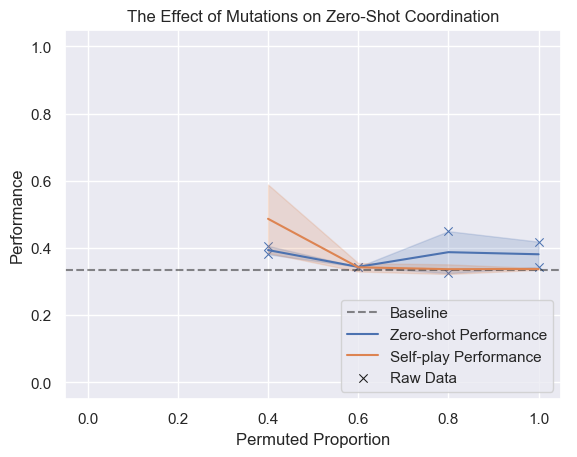

In [45]:
ax = sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], 
                  color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
ax.lines[0].set_linestyle("--")

sns.lineplot(x=X_NAME, y='Zero-Shot Coordination Score', 
             data=zs_coord_df, label='Zero-shot Performance')
sns.scatterplot(x=X_NAME, y='Zero-Shot Coordination Score', 
                data=zs_coord_df, marker='x')

sns.lineplot(x=X_NAME, y='Self-play Performance', 
             data=self_play_df, label='Self-play Performance')
# sns.scatterplot(x=X_NAME, y='Self-play Performance', 
#                 data=self_play_df, marker='x')

sns.scatterplot(x='x', y='y', data=pd.DataFrame([{'x': 100, 'y': 100}]), 
                color=(0.1, 0.1, 0.1, 0.5), marker='x', label='Raw Data')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Zero-Shot Coordination')
plt.ylabel('Performance')
plt.xlabel(X_NAME)

plt.legend(loc=4)
plt.show()

In [48]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"{experiment.param_name}={item_1[experiment.param_name]}",
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'Train Loss': training_item['loss']
    }
    for item_1 in experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history) 
])
df_train.head()

,Epoch,Experiment,Subexperiment,Train Loss
0,0,permutation_subset_size=2,subexperiment_0,1.096489
1,0,permutation_subset_size=2,subexperiment_1,1.132033
2,0,permutation_subset_size=3,subexperiment_0,1.109765
3,0,permutation_subset_size=3,subexperiment_1,1.101377
4,0,permutation_subset_size=4,subexperiment_0,1.123836


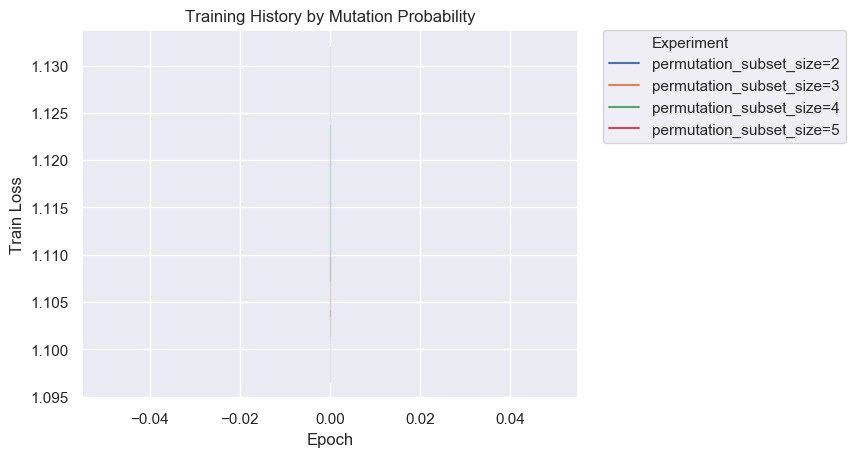

In [50]:
sns.lineplot(x='Epoch', y='Train Loss', hue='Experiment', 
             data=df_train);
#              data=df_train[df_train['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training History by Mutation Probability')
plt.show()